In [25]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.morphology import iterate_structure

from typing import Tuple, Callable, List


from pathlib import Path
import librosa

from IPython.display import Audio

%matplotlib inline

In [26]:
local_song_path = r"C:\Users\caden\Programming\bwsi\ryan-sus\audio\data\champagne.mp3"

duration = 30

recorded_audio, sampling_rate = librosa.load(local_song_path, sr=44100, mono=True, duration=duration)

c:\anaconda3\envs\week1\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [27]:
Audio(recorded_audio, rate=sampling_rate)

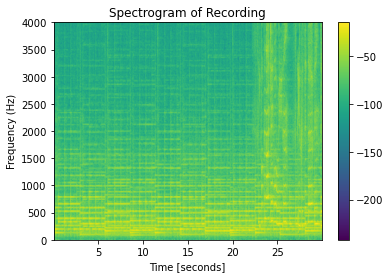

In [28]:
import matplotlib.mlab as mlab

fig, ax = plt.subplots()

spectrogram, freqs, times, im = ax.specgram(
    recorded_audio,
    NFFT=4096,
    Fs=sampling_rate,
    window=mlab.window_hanning,
    noverlap=4096 // 2,
    mode='magnitude',
    scale="dB"
)
fig.colorbar(im)

ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Recording")
ax.set_ylim(0, 4000);

In [29]:
from numba import njit

@njit
def _peaks(
    data_2d: np.ndarray, nbrhd_row_offsets: np.ndarray, nbrhd_col_offsets: np.ndarray, amp_min: float
) -> List[Tuple[int, int]]:
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    nbrhd_row_offsets : numpy.ndarray, shape-(N,)
        The row-index offsets used to traverse the local neighborhood.
        
        E.g., given the row/col-offsets (dr, dc), the element at 
        index (r+dr, c+dc) will reside in the neighborhood centered at (r, c).
    
    nbrhd_col_offsets : numpy.ndarray, shape-(N,)
        The col-index offsets used to traverse the local neighborhood. See
        `nbrhd_row_offsets` for more details.
        
    amp_min : float
        All amplitudes equal to or below this value are excluded from being
        local peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned in 
        column-major order
    """
    peaks = []  

    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            continue
        for dr, dc in zip(nbrhd_row_offsets, nbrhd_col_offsets):
            if dr == 0 and dc == 0:
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                continue

            if not (0 <= c + dc < data_2d.shape[1]):
                continue

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                break
        else:
            peaks.append((r, c))
    return peaks

def local_peak_locations(data_2d: np.ndarray, neighborhood: np.ndarray, amp_min: float):
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the specified `amp_min`.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected
    
    neighborhood : numpy.ndarray, shape-(h, w)
        A boolean mask indicating the "neighborhood" in which each
        datum will be assessed to determine whether or not it is
        a local peak. h and w must be odd-valued numbers
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned
        in column-major ordering.
    
    Notes
    -----
    The local peaks are returned in column-major order, meaning that we 
    iterate over all nbrhd_row_offsets in a given column of `data_2d` in search for
    local peaks, and then move to the next column.
    """

    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1

    nbrhd_row_indices, nbrhd_col_indices = np.where(neighborhood)
    
    nbrhd_row_offsets = nbrhd_row_indices - neighborhood.shape[0] // 2
    nbrhd_col_offsets = nbrhd_col_indices - neighborhood.shape[1] // 2

    return _peaks(data_2d, nbrhd_row_offsets, nbrhd_col_offsets, amp_min=amp_min)

In [30]:
def local_peaks_mask(data: np.ndarray, cutoff: float) -> np.ndarray:
    """Find local peaks in a 2D array of data and return a 2D array
    that is 1 wherever there is a peak and 0 where there is not.

    Parameters
    ----------
    data : numpy.ndarray, shape-(H, W)

    cutoff : float
         A threshold value that distinguishes background from foreground

    Returns
    -------
    Binary indicator, of the same shape as `data`. The value of
    1 indicates a local peak."""

    neighborhood_array = generate_binary_structure(2, 1) 

    peak_locations = local_peak_locations(data, neighborhood_array, cutoff)  

    peak_locations = np.array(peak_locations)

    mask = np.zeros(data.shape, dtype=bool)

    mask[peak_locations[:, 0], peak_locations[:, 1]] = 1
    return mask

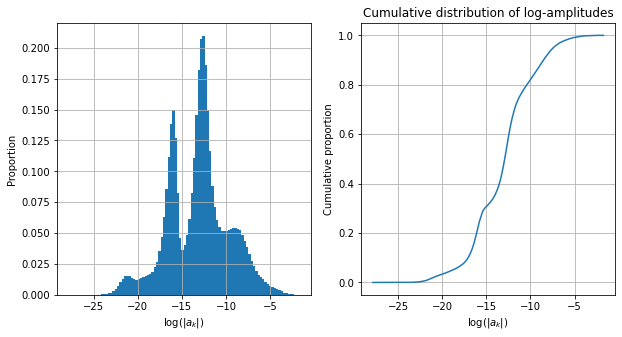

In [31]:
import numpy as np

def ecdf(data):
    """Returns (x) the sorted data and (y) the empirical cumulative-proportion
    of each datum.
    
    Parameters
    ----------
    data : numpy.ndarray, size-N
    
    Returns
    -------
    Tuple[numpy.ndarray shape-(N,), numpy.ndarray shape-(N,)]
        Sorted data, empirical CDF values"""
    data = np.asarray(data).ravel() 
    y = np.linspace(1 / len(data), 1, len(data)) 
    x = np.sort(data)
    return x, y


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))


ax1.hist(np.log(spectrogram).ravel(), bins=100, density=True)
ax1.set_xlabel(r"$\log(|a_{k}|)$")
ax1.set_ylabel(r"Proportion")
ax1.grid()

x, y = ecdf(np.log(spectrogram))
ax2.plot(x, y)

ax2.set_xlabel(r"$\log(|a_{k}|)$")
ax2.set_ylabel(r"Cumulative proportion")
ax2.set_title("Cumulative distribution of log-amplitudes")
ax2.grid(True)

In [32]:
def plot_compare(
    data: np.ndarray,
    peak_rendering_func: Callable[[np.ndarray], np.ndarray],
    cutoff: float = -np.inf,
) -> Tuple[plt.Figure, plt.Axes]:
    """Plot the original data side-by-side with the binary indicator
    for the local peaks.

    Parameters
    ----------
    data : numpy.ndarray, shape=(N, H, W)
        N 2D arrays of shape (H, W)

    peak_finding_function : Callable[[ndarray], ndarray]
        A function that will locate the 2D peaks in `data` and
        create an image with the 2D peaks 

    cutoff : float, optional (default=-np.inf)
         A threshold value that distinguishes background from foreground
         
    Returns
    -------
    Tuple[matplotlib.Figure, matplotlib.Axes]
        The figure and axes objects of the plot
    """
    fig, ax = plt.subplots()
    ax.imshow(peak_rendering_func(data, cutoff=cutoff))
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title("Peaks")
    
    

    return fig, ax

In [33]:
log_S = spectrogram.ravel()  # ravel flattens 2D spectrogram into a 1D array
ind = round(len(log_S) * 0.75)  # find the index associated with the 60th percentile log-amplitude
cutoff_log_amplitude = np.partition(log_S, ind)[ind]  # find the actual 60th percentile log-amplitude

In [34]:
cutoff_log_amplitude

1.2810586174474143e-05

[[-14.14481939 -13.8916753   -8.71495157 ... -10.64231646  -8.233166
   -8.68999778]
 [-14.12077871 -12.88977851  -8.8012863  ...  -9.42086027  -8.37416137
   -9.00489601]
 [-14.04871347 -13.11155047  -9.29742796 ...  -9.40951821  -9.26460688
  -10.11722392]
 ...
 [-12.20844108 -10.4141801   -7.18462043 ...  -6.45985178  -7.35855301
   -8.93388531]
 [-11.91988771  -9.71480265  -6.86019269 ...  -6.82715273  -6.67446556
   -8.3412372 ]
 [-11.70462988  -9.83141265  -6.60336367 ...  -7.1125768   -7.15492006
   -7.17491046]]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

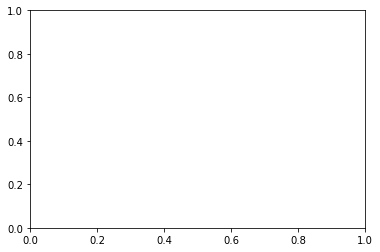

In [35]:
spectrogram = np.clip(spectrogram, 1e-20, None)
spectrogram = np.log(spectrogram)
print(spectrogram[:10])
plot_compare(spectrogram, local_peaks_mask, cutoff=cutoff_log_amplitude); # <COGLINE>